# Tutorial Five: Multicollinearity

In [1]:
from sklearn.datasets import load_diabetes
import sas7bdat
import os

import pandas as pd
import numpy as np
import random
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import math

from sklearn import preprocessing # Data Preprocessing
import statsmodels.api as sm # LSE, Ridge Regression
from statsmodels.stats.outliers_influence import variance_inflation_factor # VIF 
from statsmodels.multivariate.pca import PCA # PCR

from jupyterquiz import display_quiz 

## 数据预处理

### 1. 从scikit-learn包中载入数据集diabetes

In [2]:
path = r"../Project/diabetes2.sas7bdat"
Data = sas7bdat.SAS7BDAT(path,encoding='gb2312').to_data_frame()

In [3]:
print(Data)

          age       sex       bmi       map        tc       ldl       hdl  \
0    0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1   -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2    0.085299  0.050680  0.044451 -0.005671 -0.045599 -0.034194 -0.032356   
3   -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4    0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   
..        ...       ...       ...       ...       ...       ...       ...   
437  0.041708  0.050680  0.019662  0.059744 -0.005697 -0.002566 -0.028674   
438 -0.005515  0.050680 -0.015906 -0.067642  0.049341  0.079165 -0.028674   
439  0.041708  0.050680 -0.015906  0.017282 -0.037344 -0.013840 -0.024993   
440 -0.045472 -0.044642  0.039062  0.001215  0.016318  0.015283 -0.028674   
441 -0.045472 -0.044642 -0.073030 -0.081414  0.083740  0.027809  0.173816   

          tch       ltg       glu  ...   ldl_tch   ldl_ltg   ldl_glu  \
0  

In [38]:
p = Data.shape[1]-1
n = Data.shape[0]
print("The number of features is",p)
print("The sample size is",n)

The number of features is 64
The sample size is 442


### 2. 通过阅读以下参考文献，定义清楚问题背景、数据中响应变量和自变量的概念、取值范围等信息。

原始数据一次项为10项，分别为AGE SEX BMI BP S1 S2 S3 S4 S5 S6，另外有Y为响应变量；而二次项共64项，包括前十项以及其交叉项，最后加上一列响应变量Y。

### 3. 以自己的学号作为随机种子，采用留出法划分训练集和测试集，样本比例为7.5:2.5。

In [39]:
n_train = 331 # 75% * n
n_test = n-n_train
seed = 10205501406
random.seed(seed)
index = range(0,n)
index_selected = random.sample(index,n_train)
index_selected.sort()

Data_train = Data.loc[index_selected]
Data_test = Data.drop(index = index_selected)

In [6]:
Data_train.head()

,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu,...,ldl_tch,ldl_ltg,ldl_glu,hdl_tch,hdl_ltg,hdl_glu,tch_ltg,tch_glu,ltg_glu,y
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,...,-0.022038,-0.031125,-0.000922,0.033494,0.000852,0.031150,-0.028191,-0.017658,-0.027794,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,...,-0.011564,0.012973,0.023783,-0.023815,-0.094506,-0.140378,0.025298,0.053034,0.104013,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,...,-0.022063,-0.018016,0.004913,0.032956,0.018281,0.032795,-0.027332,-0.017236,-0.022304,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,...,-0.009984,-0.003373,-0.019109,0.008159,0.001898,0.021514,-0.012045,-0.024872,-0.025042,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,...,-0.024091,-0.026846,-0.029687,0.030984,0.014489,0.005386,-0.025575,-0.016180,0.008735,135.0


In [7]:
Data_test.head()

,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu,...,ldl_tch,ldl_ltg,ldl_glu,hdl_tch,hdl_ltg,hdl_glu,tch_ltg,tch_glu,ltg_glu,y
6,-0.045472,0.050680,-0.047163,-0.015999,-0.040096,-0.024800,0.000779,-0.039493,-0.062913,-0.038357,...,-0.008066,0.018496,0.006298,0.030803,0.019267,0.013254,0.021137,0.011224,0.026986,138.0
7,0.063504,0.050680,-0.001895,0.066630,0.090620,0.108914,0.022869,0.017703,-0.035817,0.003064,...,0.006841,-0.101758,-0.006939,0.038984,0.001868,0.015502,-0.039520,-0.017491,-0.023007,63.0
9,-0.070900,-0.044642,0.039062,-0.033214,-0.012577,-0.034508,-0.024993,-0.002592,0.067736,-0.013504,...,-0.022051,-0.067329,-0.004105,0.032597,-0.017875,0.021517,-0.030603,-0.017869,-0.038958,310.0
10,-0.096328,-0.044642,-0.083808,0.008101,-0.103389,-0.090561,-0.013948,-0.076395,-0.062913,-0.034215,...,0.085251,0.109597,0.052328,0.051393,0.040201,0.024659,0.066290,0.032830,0.021822,101.0
11,0.027178,0.050680,0.017506,-0.033214,-0.007073,0.045972,-0.065491,0.071210,-0.096433,-0.059067,...,0.027982,-0.113478,-0.072303,-0.056210,0.163067,0.100925,-0.160745,-0.101251,0.092040,69.0


In [8]:
X_train = Data_train.drop(columns = ['y'],axis=1)
Y_train = Data_train.y
X_test = Data_test.drop(columns = ["y"],axis=1)
Y_test = Data_test.y

# X_train_standardized=X_train.values

X_train_standardized = preprocessing.scale(X_train, with_mean = True, with_std=True)/np.sqrt(n_train)
Y_train_centered = preprocessing.scale(Y_train, with_mean = True, with_std=False)
Y_train_mean = np.average(Y_train)
X_test_standardized = preprocessing.scale(X_test, with_mean = True, with_std=True)/np.sqrt(n_test)
print(X_train_standardized)

[[ 0.04395604  0.05786431  0.07156889 ... -0.03392584 -0.02066368
  -0.03199881]
 [-0.00285413 -0.0522109  -0.06020568 ...  0.0273009   0.05971011
   0.11637379]
 [ 0.09927714  0.05786431  0.05148895 ... -0.03294217 -0.02018365
  -0.02581889]
 ...
 [-0.00710958  0.05786431 -0.01879081 ... -0.04661584  0.01242957
  -0.04214137]
 [ 0.0482115   0.05786431 -0.01879081 ... -0.02121355 -0.02552255
  -0.04036126]
 [-0.05391975 -0.0522109   0.04521397 ... -0.00644764 -0.03708047
  -0.04991816]]


## 模型构建
### 4. 判断用于建模的特征数据中是否存在多重共线性？提供合适的判断方案。

首先可以通过热力图来观察一下特征之间的自身相关性。

<AxesSubplot:>

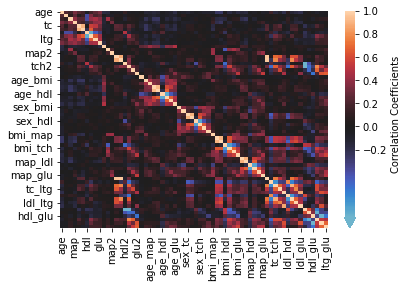

In [9]:
pcorr = X_train.corr(method = 'pearson')
tick_ = (np.arange(0,13,2)-2)/10
dict_ = {"orientation":'vertical',
         'label':'Correlation Coefficients',
         "drawedges":False,
         "ticklocation":"top",
         "extend":"min",
        "filled":True,
         "alpha":0.8,
         "cmap":"cmap",
         "ticks":tick_}
sns.heatmap(pcorr,cbar_kws= dict_,center=0)

因为自变量数量过多，具体关系无法看得很清楚，但是从浅色区域可以观察到，相邻自变量之间存在相关性。
- 方差扩大因子法

设置临界值为 5。

In [10]:
vif_cv = 5 # The criterion value of VIF

1. 根据方差扩大因子的定义，可以通过矩阵计算来确定方差扩大因子。

In [11]:
# Method One
C = np.linalg.inv(np.dot(X_train_standardized.T,X_train_standardized))
VIF_1 = np.diag(C)
print("The VIF's are", np.round(VIF_1,2))

The VIF's are [1.60000000e+00 1.58000000e+00 2.71000000e+00 1.93000000e+00
 1.13047516e+06 8.69491600e+05 1.58971170e+05 2.79400000e+01
 1.29310430e+05 1.86000000e+00 1.79000000e+00 2.73000000e+00
 1.89000000e+00 1.68879200e+04 8.14546000e+03 8.56210000e+02
 1.53260000e+02 1.00684000e+03 3.71000000e+00 2.09000000e+00
 2.25000000e+00 2.45000000e+00 1.40120000e+02 9.27800000e+01
 3.11500000e+01 1.70000000e+01 1.91300000e+01 2.72000000e+00
 2.32000000e+00 2.17000000e+00 1.20370000e+02 7.53200000e+01
 2.54300000e+01 1.47600000e+01 1.79400000e+01 2.18000000e+00
 2.63000000e+00 1.57040000e+02 1.13940000e+02 3.26900000e+01
 2.54000000e+01 2.72800000e+01 3.02000000e+00 1.62950000e+02
 1.15730000e+02 3.53000000e+01 1.69200000e+01 2.65500000e+01
 3.11000000e+00 4.40575600e+04 4.62923000e+03 1.09613000e+03
 5.70068300e+04 1.28890000e+02 3.13101000e+03 6.34540000e+02
 3.94287300e+04 8.98800000e+01 4.71240000e+02 6.81495000e+03
 3.55000000e+01 1.95070000e+02 2.29600000e+01 2.94400000e+01]


2. 使用Python中statsmodel包中的自带函数variance_inflation_factor。

In [12]:
# Method Two
VIF_2 = [variance_inflation_factor(X_train_standardized[:,0:p], i) for i in range(p)]
print("The VIF's are", np.round(VIF_2,2))

The VIF's are [1.60000000e+00 1.58000000e+00 2.71000000e+00 1.93000000e+00
 1.13047516e+06 8.69491600e+05 1.58971170e+05 2.79400000e+01
 1.29310430e+05 1.86000000e+00 1.79000000e+00 2.73000000e+00
 1.89000000e+00 1.68879200e+04 8.14546000e+03 8.56210000e+02
 1.53260000e+02 1.00684000e+03 3.71000000e+00 2.09000000e+00
 2.25000000e+00 2.45000000e+00 1.40120000e+02 9.27800000e+01
 3.11500000e+01 1.70000000e+01 1.91300000e+01 2.72000000e+00
 2.32000000e+00 2.17000000e+00 1.20370000e+02 7.53200000e+01
 2.54300000e+01 1.47600000e+01 1.79400000e+01 2.18000000e+00
 2.63000000e+00 1.57040000e+02 1.13940000e+02 3.26900000e+01
 2.54000000e+01 2.72800000e+01 3.02000000e+00 1.62950000e+02
 1.15730000e+02 3.53000000e+01 1.69200000e+01 2.65500000e+01
 3.11000000e+00 4.40575600e+04 4.62923000e+03 1.09613000e+03
 5.70068300e+04 1.28890000e+02 3.13101000e+03 6.34540000e+02
 3.94287300e+04 8.98800000e+01 4.71240000e+02 6.81495000e+03
 3.55000000e+01 1.95070000e+02 2.29600000e+01 2.94400000e+01]


可以观察到使用method1和method2计算出来的方差扩大因子是一样的。

In [49]:
# Method Three
X_5 = X_train_standardized[:,4]
X_others = X_train_standardized[:,5:p]
model_vif = sm.OLS(X_5,X_others).fit()
X_5_VIF = 1/(1-model_vif.rsquared)
print("The VIF of the fifth feature is", np.round(X_1_VIF,2))

The VIF of the fifth feature is 1107739.49


这里选取前五个自变量，可以发现其方差扩大因子超级大，远大于临界值，说明其多重共线性是严重的。

- 特征值方法

通过计算 𝐗′𝐗 的特征值来判断数据多重共线性的程度。

In [15]:
R = np.dot(X_train_standardized.T,X_train_standardized)
W, V = np.linalg.eig(R)
W = -1* np.sort(-1*W)
W_diag = np.diag(W)
V = V.T
print("The eigen values are", np.round(W,4))

The eigen values are [1.06367e+01 6.03830e+00 5.29970e+00 4.17950e+00 3.51890e+00 2.77800e+00
 2.55830e+00 2.43240e+00 2.17240e+00 1.89020e+00 1.73500e+00 1.53430e+00
 1.41340e+00 1.29740e+00 1.24320e+00 1.09210e+00 1.05390e+00 1.00020e+00
 9.02800e-01 8.02000e-01 7.60700e-01 7.09000e-01 6.84500e-01 6.19300e-01
 5.92300e-01 5.85300e-01 5.49900e-01 5.24100e-01 5.02300e-01 4.82700e-01
 4.47300e-01 4.37100e-01 4.11000e-01 3.47200e-01 3.17800e-01 2.94500e-01
 2.84200e-01 2.59300e-01 2.56800e-01 2.37300e-01 1.95300e-01 1.78900e-01
 1.66500e-01 1.57900e-01 8.99000e-02 7.82000e-02 5.62000e-02 3.75000e-02
 3.42000e-02 3.22000e-02 2.35000e-02 2.12000e-02 1.24000e-02 1.03000e-02
 5.60000e-03 4.20000e-03 3.90000e-03 3.40000e-03 2.90000e-03 2.40000e-03
 2.10000e-03 4.00000e-04 0.00000e+00 0.00000e+00]


In [16]:
Condition_Number = np.sqrt(np.max(W)/np.min(W))
print("The condition number is",np.round(Condition_Number,4))

The condition number is 5090.5826


In [17]:
model_ols = sm.OLS(Y_train_centered,X_train_standardized).fit()
print("The condition number is",round(model_ols.condition_number,4))

The condition number is 5090.5825


In [ ]:
可以发现，这里计算出来的条件值也很大。

### 5. 构建线性回归模型Model_1

In [18]:
X_train_withintercept = sm.add_constant(X_train)
model_1 = sm.OLS(Y_train,X_train_withintercept).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     7.227
Date:                Wed, 09 Nov 2022   Prob (F-statistic):           1.50e-31
Time:                        15:19:12   Log-Likelihood:                -1739.8
No. Observations:                 331   AIC:                             3610.
Df Residuals:                     266   BIC:                             3857.
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        155.6401      2.945     52.854      0.000     149.842     161.438
age           51.2268     76.581      0.669      0.504     -99.554     202.008
sex         -268.8649     75.199     -3.575      0.000    -416.926    -120.804
bmi          447.8763     99.196      4.515      0.000     252.567     643.185
map          340.9305     81.422      4.187      0.000     180.617     501.244
tc         -3.684e+04   6.47e+04     -0.569      0.570   -1.64e+05    9.06e+04
ldl         3.238e+04   5.69e+04      0.569      0.570   -7.96e+04    1.44e+05
hdl          1.36e+04   2.42e+04      0.562      0.574    -3.4e+04    6.12e+04
tch          -30.4083    318.628     -0.095      0.924    -657.763     596.946
ltg         1.273e+04   2.13e+04      0.598      0.550   -2.92e+04    5.46e+04
glu          122.6224     80.619      1.521      0.129     -36.110     281.354
age2          -5.5146     82.895     -0.067      0.947    -168.728     157.699
bmi2          63.0349    102.886      0.613      0.541    -139.539     265.608
map2         -44.0289     78.444     -0.561      0.575    -198.478     110.420
tc2         2104.6831   7757.430      0.271      0.786   -1.32e+04    1.74e+04
ldl2         268.9691   5803.992      0.046      0.963   -1.12e+04    1.17e+04
hdl2         434.0327   1922.008      0.226      0.822   -3350.252    4218.317
tch2        1471.2789    781.428      1.883      0.061     -67.293    3009.850
ltg2        2190.7087   1857.618      1.179      0.239   -1466.798    5848.215
glu2         -14.6809    111.910     -0.131      0.896    -235.023     205.661
age_sex      124.2630     88.389      1.406      0.161     -49.768     298.294
age_bmi      -99.1106     92.369     -1.073      0.284    -280.978      82.757
age_map       88.0290     92.720      0.949      0.343     -94.529     270.587
age_tc        31.9475    732.414      0.044      0.965   -1410.119    1474.014
age_ldl     -212.7334    594.122     -0.358      0.721   -1382.514     957.047
age_hdl      106.7541    339.675      0.314      0.754    -562.039     775.547
age_tch      222.6064    248.283      0.897      0.371    -266.245     711.457
age_ltg      -85.9359    267.530     -0.321      0.748    -612.682     440.810
age_glu      172.2985     99.446      1.733      0.084     -23.502     368.099
sex_bmi       36.8630     91.902      0.401      0.689    -144.084     217.810
sex_map       81.8598     86.132      0.950      0.343     -87.728     251.448
sex_tc       769.7530    667.827      1.153      0.250    -545.146    2084.652
sex_ldl     -721.1049    528.815     -1.364      0.174   -1762.301     320.091
sex_hdl     -208.9125    306.232     -0.682      0.496    -811.859     394.034
sex_tch       20.5195    232.421      0.088      0.930    -437.100     478.139
sex_ltg     -251.1841    251.954     -0.997      0.320    -747.261     244.893
se

### 6. 构建岭回归模型Model_2

岭回归估计为
$$
\hat{\mathbf{\beta}}(k) = (\mathbf{X}'\mathbf{X} + k \mathbf{I})^{-1} \mathbf{X}' \mathbf{y}.
$$

使用statmodels.api包中OLS.fit_regularized可以实现。

In [19]:
## Ridge Regression
alpha  = 0.1 # A hyperparameter in Ridge Regression (equivalently but not equally, k in slides)
model_rr = sm.OLS(Y_train_centered,X_train_standardized).fit_regularized(L1_wt=0,alpha = alpha)
print("The parameters in the ridge regression are ",np.round(model_rr.params,2))

The parameters in the ridge regression are  [  6.57   0.87  22.98  16.82   8.17   7.1  -15.32  16.35  21.09  14.71
  -0.82   9.9    7.02   1.94   1.65  -5.66   4.99   1.39   5.74   2.56
  -3.37   2.26  -4.32  -5.53  -2.09  -1.11   0.9    1.12  -0.21   2.07
  -0.12  -2.29   2.68  -0.76   1.27   1.1    6.04  -3.62  -5.58  -1.44
   0.54   2.68   5.71  -1.32  -3.8   -0.18  -0.76   3.71   2.62   1.5
  -0.77   3.24   0.31   2.68   3.25   1.35  -4.31  -0.25   0.97   2.75
  -2.9    0.82   5.68   6.25]


其中超参数 $\alpha=k/n$

In [20]:
alpha_num = 100
alpha_vec = np.array(list(range(0,alpha_num)))/alpha_num/1000
RR_coef = []
RR_vif = []

for alpha in alpha_vec:
    rr_model = sm.OLS(Y_train_centered,X_train_standardized).fit_regularized(L1_wt=0,alpha = alpha)
    rr_coef = rr_model.params
    RR_coef.append(rr_coef)

下面通过岭迹图来去认定最优的超参数。

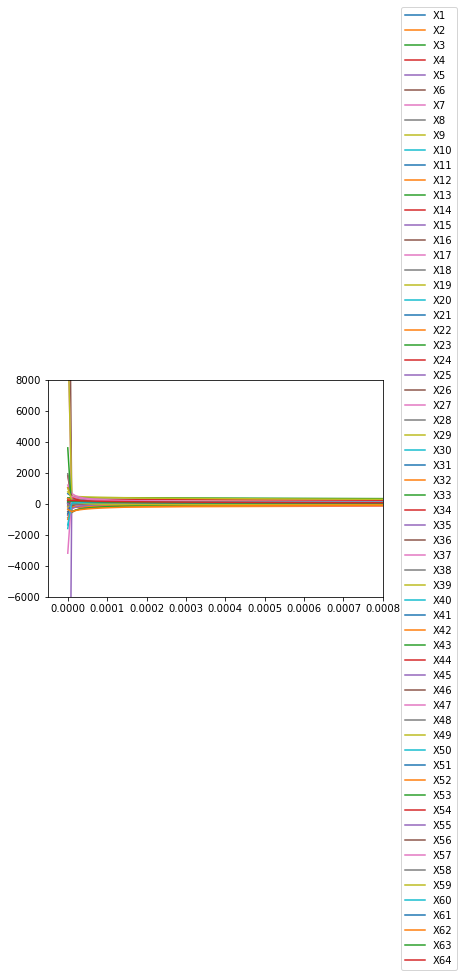

In [21]:
for i in range(p):
    plt.plot(alpha_vec, np.array(RR_coef)[:,i],label = "X%d"%(i+1))

plt.axis([-0.00005,0.0008,-6000,8000])    
plt.legend(loc="right",bbox_to_anchor=(1.25,0.5),borderaxespad=1)


因为自变量过多，从上图也很难直接看出最优的超参数，因此可以计算不同$\alpha$下的VIF值，其复合临界值条件时，可以进行选择。

In [22]:
C_k = []
for alpha in alpha_vec:
    k = alpha * n_train
    c_k = np.linalg.inv(X_train_standardized.T @ X_train_standardized + k * np.eye(p)) @ X_train_standardized.T @ X_train_standardized @ np.linalg.inv(X_train_standardized.T @ X_train_standardized + k * np.eye(p))
    C_k.append(np.mean(np.diag(c_k)))

alpha_best = alpha_vec[np.min(np.where(np.array(C_k) < vif_cv))]
print("The chosen value of alpha is", alpha_best)

The chosen value of alpha is 4e-05


In [26]:
model_rr_best = sm.OLS(Y_train_centered,X_train_standardized).fit_regularized(L1_wt=0,alpha = alpha_best)
model_rr_best_coef = model_rr_best.params
print(model_rr_best_coef)

[  49.18727069 -209.59909726  393.31498016  288.79412849  -18.69428418
  -34.98887568 -110.68624965   58.70066223  452.28552038  105.59352164
    8.56283294   60.90136242  -49.86567536   67.09812668 -122.7738872
 -161.72013873  382.15277195  163.77752245    9.54041553  126.7286674
  -84.57046454   80.02853587   49.96810357 -156.00731847   65.09918099
  127.81976687  -63.99186267  107.46572671   44.79407627   52.93282717
  244.66979557 -300.57351992    8.39526631   65.8828763  -107.43982286
   14.88396914  169.99052531 -264.93812755  199.08444868   38.51421567
 -101.24225078   62.16441333  103.43664844  185.72820868  -30.99995111
 -114.32316045 -132.98761051    4.96939327 -168.60370417   94.24212656
  139.19905777 -159.39372414 -303.71741972  -21.53842278 -121.27733869
   51.51580821  323.64712523   -4.5036802    27.09635228   71.2965431
  156.596778   -352.25736379  156.93639597  190.53269687]


### 7. 构建主成分回归模型Model_3

在PCR模型中，先构建特征的主成分。

In [27]:
model_pca = PCA(X_train_standardized,standardize = False, demean = True)
model_pca_cr = model_pca.eigenvals # contribution rate of each component
print("The percentages of total variance are", np.around(model_pca_cr,4))

The percentages of total variance are [1.06367e+01 6.03830e+00 5.29970e+00 4.17950e+00 3.51890e+00 2.77800e+00
 2.55830e+00 2.43240e+00 2.17240e+00 1.89020e+00 1.73500e+00 1.53430e+00
 1.41340e+00 1.29740e+00 1.24320e+00 1.09210e+00 1.05390e+00 1.00020e+00
 9.02800e-01 8.02000e-01 7.60700e-01 7.09000e-01 6.84500e-01 6.19300e-01
 5.92300e-01 5.85300e-01 5.49900e-01 5.24100e-01 5.02300e-01 4.82700e-01
 4.47300e-01 4.37100e-01 4.11000e-01 3.47200e-01 3.17800e-01 2.94500e-01
 2.84200e-01 2.59300e-01 2.56800e-01 2.37300e-01 1.95300e-01 1.78900e-01
 1.66500e-01 1.57900e-01 8.99000e-02 7.82000e-02 5.62000e-02 3.75000e-02
 3.42000e-02 3.22000e-02 2.35000e-02 2.12000e-02 1.24000e-02 1.03000e-02
 5.60000e-03 4.20000e-03 3.90000e-03 3.40000e-03 2.90000e-03 2.40000e-03
 2.10000e-03 4.00000e-04 0.00000e+00 0.00000e+00]


在计算出$\mathbf{X}'\mathbf{X}$的特征值后，通过代码进行验证。

In [52]:
Corr_Mat = X_train_standardized.T @ X_train_standardized
Lambda, V = np.linalg.eig(Corr_Mat)
Lambda = sorted(Lambda,reverse = True)
print("The eigen values of X'X are ", np.around(Lambda,4))

The eigen values of X'X are  [1.06367e+01 6.03830e+00 5.29970e+00 4.17950e+00 3.51890e+00 2.77800e+00
 2.55830e+00 2.43240e+00 2.17240e+00 1.89020e+00 1.73500e+00 1.53430e+00
 1.41340e+00 1.29740e+00 1.24320e+00 1.09210e+00 1.05390e+00 1.00020e+00
 9.02800e-01 8.02000e-01 7.60700e-01 7.09000e-01 6.84500e-01 6.19300e-01
 5.92300e-01 5.85300e-01 5.49900e-01 5.24100e-01 5.02300e-01 4.82700e-01
 4.47300e-01 4.37100e-01 4.11000e-01 3.47200e-01 3.17800e-01 2.94500e-01
 2.84200e-01 2.59300e-01 2.56800e-01 2.37300e-01 1.95300e-01 1.78900e-01
 1.66500e-01 1.57900e-01 8.99000e-02 7.82000e-02 5.62000e-02 3.75000e-02
 3.42000e-02 3.22000e-02 2.35000e-02 2.12000e-02 1.24000e-02 1.03000e-02
 5.60000e-03 4.20000e-03 3.90000e-03 3.40000e-03 2.90000e-03 2.40000e-03
 2.10000e-03 4.00000e-04 0.00000e+00 0.00000e+00]


通过比对发现，二者的值没有区别。

接下来选择超参数：主成分个数。通过绘制scree plot来进行主观判断。

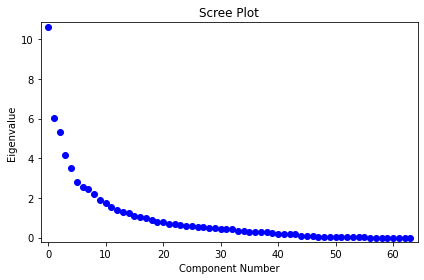

In [29]:
fig = model_pca.plot_scree(log_scale = False)

同时可以计算其信息增量（每增加一个主成分），因此绘制scree plot来观察其累计贡献率。

The cummulative percentages of total variance are [0.1662 0.2605 0.3434 0.4087 0.4636 0.507  0.547  0.585  0.619  0.6485
 0.6756 0.6996 0.7217 0.7419 0.7614 0.7784 0.7949 0.8105 0.8246 0.8372
 0.849  0.8601 0.8708 0.8805 0.8898 0.8989 0.9075 0.9157 0.9235 0.9311
 0.9381 0.9449 0.9513 0.9567 0.9617 0.9663 0.9707 0.9748 0.9788 0.9825
 0.9856 0.9884 0.991  0.9934 0.9948 0.9961 0.9969 0.9975 0.9981 0.9986
 0.9989 0.9993 0.9995 0.9996 0.9997 0.9998 0.9998 0.9999 0.9999 1.
 1.     1.     1.     1.    ]


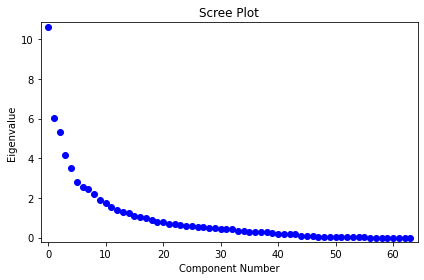

In [30]:
model_pca_ccr = np.cumsum(model_pca_cr)/p # cummulative contribution rate
print("The cummulative percentages of total variance are", np.around(model_pca_ccr,4))

fig = model_pca.plot_scree(log_scale = False)

选取主成分，要求其累计贡献率达到85%。

In [55]:
pca_cv = 0.85

In [56]:
num_pca = np.min(np.where(model_pca_ccr > pca_cv))
print("The appropriate number of component is", (num_pca+1))

The appropriate number of component is 22


最佳主成分个数为22。（虽然正常来说应该不超过6个）

最后构建主成分来代替原始特征，并拟合回归模型；通过线性变换来估计主成分回归中的参数。

In [57]:
model_pca_selected = PCA(X_train_standardized,  standardize = False,  demean = True)
V = model_pca_selected.loadings
Z_train_standardized= X_train_standardized @ V[:,0:(num_pca+1)]
model_pcr = sm.OLS(Y_train_centered, Z_train_standardized).fit()
model_pcr_coef = V.T @ np.pad(model_pcr.params,(0,p-(num_pca+1)))
print(model_pcr_coef)

[  31.64514126  -87.0640497    35.42076033  -21.74276651   25.1368363
  -86.9997658    29.57686656  -24.20677382   92.60103624    4.25962194
   17.20312271   95.23542076 -160.88848535  -50.22052549  -21.4689416
  -53.76083077  -12.26890518  -25.6538251  -101.18046153  149.0209172
  -27.33113385   43.78598147   65.42582837   39.59455104  173.06349843
  -36.46876517  224.39088252   -8.63737177  -60.3047631    33.30957996
  -46.16583603  -92.90026034  204.60530321   29.5615031    86.94343733
 -186.72364988   84.42328373  -66.55982519  -12.22593065  -32.21613177
  -47.15029132  194.62677498  -36.92885881  -36.67419706  -34.91204804
  -51.20543564  -29.56013147   14.97954988   12.259338     23.7876361
   -7.07468394   -7.08433808   30.82951756  -34.91007149   92.47695574
 -120.62902269  -16.53773432   80.28942301   12.56838477   28.90698879
  -10.2644987    69.6746599    50.86233647 -114.14998843]


## 模型评价

### 8. 利用RMSE，比较Model_1、Model_2、Model_3在测试集上的预测效果。请进行评论。

RMSE衡量指标：

$$
RMSE = \sqrt{n^{-1}\sum_{i=1}^n (\hat{y}_i - y_i)^2}
$$

1. 构建线性回归模型。对于每一个数据$(\mathbf{x}_i,y_i)$，线性回归模型的预测结果为
$$
y_i^{\text{ols}} = \hat{\beta}_0 + \mathbf{x}_i \hat{\mathbf{\beta}}^{\text{ols}}
$$
这里
- $\hat{\beta}_0$采用训练集中响应变量的样本均值来估计；
- $\hat{\mathbf{\beta}}^{\text{ols}}$采用最小二乘估计；

In [34]:
model_ols_coef = model_ols.params 
Y_pred_ols = Y_train_mean + X_test_standardized @ model_ols_coef
ols_rmse = np.sqrt(np.mean((Y_pred_ols-Y_test)**2))
print("The RMSE in the ordinary regression is", round(ols_rmse,4))

The RMSE in the ordinary regression is 167.8528


2. 构建岭回归模型。对于每一个数据$(\mathbf{x}_i,y_i)$，岭回归模型的预测结果为
$$
y_i^{\text{rr}} = \hat{\beta}_0 + \mathbf{x}_i \hat{\mathbf{\beta}}^{\text{rr}}
$$
这里
- $\hat{\beta}_0$采用训练集中响应变量的样本均值来估计；
- $\hat{\mathbf{\beta}}^{\text{rr}}$采用岭回归估计；


In [36]:
Y_pred_rr = Y_train_mean + X_test_standardized @ model_rr_best_coef
rr_rmse = np.sqrt(np.mean((Y_pred_rr-Y_test)**2))

print("The RMSE in the ridge regression is", round(rr_rmse,4))
    

The RMSE in the ridge regression is 87.0656


3. 构建主成分回归模型。对于每一个数据$(\mathbf{x}_i,y_i)$，主成分回归模型的预测结果为
$$
y_i^{\text{pcr}} = \hat{\beta}_0 + \mathbf{x}_i \hat{\mathbf{\beta}}^{\text{pcr}}
$$
这里
- $\hat{\beta}_0$采用训练集中响应变量的样本均值来估计；
- $\hat{\mathbf{\beta}}^{\text{pcrr}}$采用主成分回归估计；


In [37]:
Y_pred_pcr = Y_train_mean + X_test_standardized @ model_pcr_coef
pcr_rmse = np.sqrt(np.mean((Y_pred_pcr-Y_test)**2))

print("The RMSE in the ordinary regression is", round(pcr_rmse,4))

The RMSE in the ordinary regression is 92.3889


从预测的角度来看，预测效果：岭回归模型>主成分回归模型>普通线性回归模型。